In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone "https://github.com/maria-natale/ProgettoFVAB"

Cloning into 'ProgettoFVAB'...
remote: Enumerating objects: 246, done.
remote: Counting objects: 100% (246/246), done.
remote: Compressing objects: 100% (203/203), done.
remote: Total 246 (delta 89), reused 133 (delta 31), pack-reused 0
Receiving objects: 100% (246/246), 1.10 MiB | 3.49 MiB/s, done.
Resolving deltas: 100% (89/89), done.


In [55]:
!python "/content/ProgettoFVAB/Code/create_dataset2.py"

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
sh: 0: getcwd() failed: No such file or directory
(151, 2)
(52, 2)
(56, 2)
100% 248/248 [00:03<00:00, 64.34it/s]
(148, 2)
148it [00:24,  6.15it/s]


In [32]:
import os
import pandas as pd
import numpy as np

path_git = '/content/ProgettoFVAB'
filename = '4_7'
path_drive = '/content/drive/MyDrive/Casillo&Natale/dataset'
dataset_dir = 'dataset_4_7/datasetCSV'
"""LANGUAGES = {
  1:'Italiano',
  2:'Inglese',
  3: 'Tedesco',
  4:'Spagnolo',
  5: 'Olandese',
  6:'Russo',
  7: 'Giapponese'}
LANGUAGES_N = {
    1:0,
    2:1,
    3:2,
    4:3,
    5:4,
    6:5,
    7:6
}"""
LANGUAGES = {
    4:'Spagnolo',
  7: 'Giapponese'}
LANGUAGES_N = {
    4:0,
    7:1
}

MAX_LINES = 350

# Caricamento dei dati

In [49]:
# load dataset
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM, Bidirectional
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler

# load a single file as a numpy array
def load_file(filepath):
    dataframe = read_csv(filepath, header= None)
    return dataframe.values

# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    loaded = list()
    for name in filenames:
        data = read_csv(prefix+name)
        print(data.shape)
        data = scaler.fit_transform(data)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix= ''):
    filepath = path_drive+'/'+dataset_dir+'/features/'
    os.chdir(os.path.join(filepath, group))
    filenames = []
    filenames = [group+'/feature'+str(i)+'.csv' for i in range(0,66)]
    # load input data
    X= load_group(filenames, filepath)
    #load y 
    os.chdir(os.path.join(path_drive, dataset_dir, 'csv'))
    y = read_csv(filename+'_'+group.split('_')[0]+'_targets_1.csv')
    # load class output
    return X,y

# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix)
    print(trainX.shape, trainy.shape)
    # load all test
    testX, testy = load_dataset_group('test', prefix)
    print(testX.shape, testy.shape)
    validationX, validationy = load_dataset_group('validation', prefix)
    trainy['language'] = trainy['language'].map(LANGUAGES_N)
    testy['language'] = testy['language'].map(LANGUAGES_N)
    validationy['language'] = validationy['language'].map(LANGUAGES_N)
    trainy = to_categorical(trainy, len(LANGUAGES_N))
    testy = to_categorical(testy, len(LANGUAGES_N))
    validationy = to_categorical(validationy, len(LANGUAGES_N))
    print(trainX.shape, trainy.shape, testX.shape, testy.shape, validationX.shape, validationy.shape)
    return trainX, trainy, testX, testy, validationX, validationy

    
  

# Definizione del modello

In [50]:
import tensorflow as tf
from keras.callbacks import EarlyStopping

def create_model(trainX, trainy, testX, testy):
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], len(LANGUAGES_N.keys())
    # Initialising the RNN
    model = Sequential()
    model.add(Bidirectional(LSTM(units = 100, return_sequences = True, input_shape = (n_timesteps, n_features))))
    model.add(Dropout(0.8))

    # Adding a second LSTM layer and Dropout layer
    model.add(Bidirectional(LSTM(units = 100, return_sequences = True)))
    model.add(Dropout(0.8))

    # Adding a third LSTM layer and Dropout layer
    model.add(Bidirectional(LSTM(units = 100)))
    model.add(Dropout(0.8))

    # Adding the output layer
    model.add(Dense(n_outputs, activation='softmax'))

    opt = tf.keras.optimizers.Adam(lr=0.0001, decay=1e-6)
    model.compile(
      loss='categorical_crossentropy',
      optimizer=opt,
      metrics=['accuracy']
    )

    return model
    



# Sperimentazione Spagnolo Giapponese con Early Stopping

In [51]:
def run_experiment(model, trainX, trainy, validationX, validationy, testX, testy):
  verbose, epochs, batch_size = 0, 30, 32
  #model = create_model(trainX, trainy,  validationX, validationy)
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 10)
  history = model.fit(trainX, trainy, epochs = epochs, batch_size = batch_size, validation_data = (validationX, validationy), callbacks = [es]) 
  model.summary()
  model.evaluate(testX, testy)
  predictions = model.predict_classes(testX) 
  print(predictions)
  return history, predictions


In [53]:
# run the experiment
trainX, trainy, testX, testy, validationX, validationy = load_dataset(path_drive+'/'+dataset_dir)
model = create_model(trainX, trainy, validationX, validationy)
history, predictions = run_experiment(model, trainX, trainy, validationX, validationy, testX, testy)

(156, 350)
(156, 350)
(156, 350)
(156, 350)
(156, 350)
(156, 350)
(156, 350)
(156, 350)
(156, 350)
(156, 350)
(156, 350)
(156, 350)
(156, 350)
(156, 350)
(156, 350)
(156, 350)
(156, 350)
(156, 350)
(156, 350)
(156, 350)
(156, 350)
(156, 350)
(156, 350)
(156, 350)
(156, 350)
(156, 350)
(156, 350)
(156, 350)
(120, 350)
(120, 350)
(120, 350)
(120, 350)
(120, 350)
(120, 350)
(120, 350)
(120, 350)
(120, 350)
(120, 350)
(120, 350)
(120, 350)
(120, 350)
(120, 350)
(120, 350)
(120, 350)
(120, 350)
(120, 350)
(120, 350)
(120, 350)
(120, 350)
(120, 350)
(120, 350)
(120, 350)
(120, 350)
(120, 350)
(120, 350)
(120, 350)
(120, 350)
(120, 350)
(120, 350)
(120, 350)
(120, 350)
(120, 350)
(120, 350)
(120, 350)
(120, 350)
(120, 350)


ValueError: ignored

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc

testy = np.argmax(testy, axis=1)
vis_arr = multilabel_confusion_matrix(testy, predictions, labels = list(LANGUAGES_N.values()))
print(vis_arr)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in list(LANGUAGES_N.values()):
    fpr[i], tpr[i], _ = roc_curve(testy == i, predictions == i)
    roc_auc[i] = auc(fpr[i], tpr[i])



[[[11 12]
  [ 4 28]]

 [[28  4]
  [12 11]]]


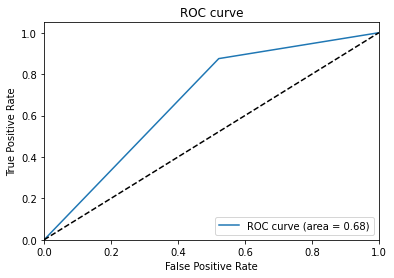

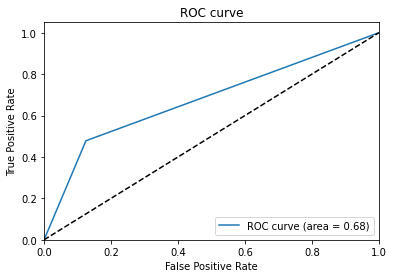

In [ ]:
import matplotlib.pyplot as plt

# Plot of a ROC curve for a specific class
for i in list(LANGUAGES_N.values()):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("Confusion Matrix for the class - " + class_label)

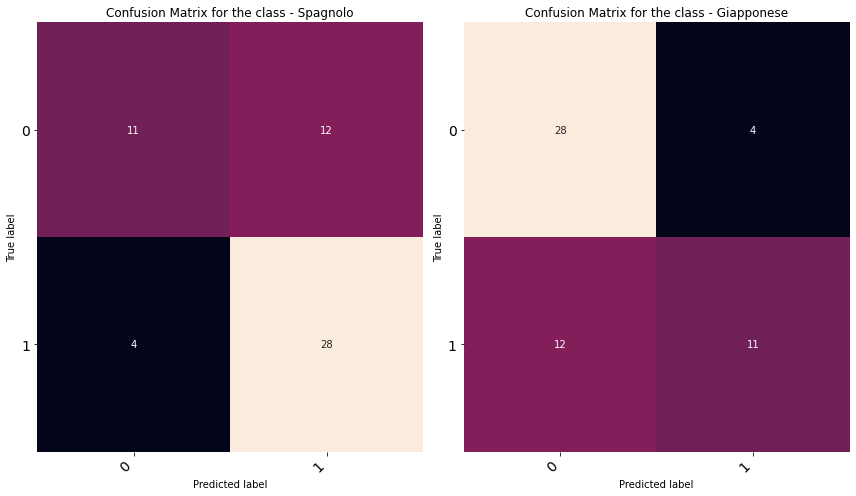

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 7))
labels = list(LANGUAGES.values())
for axes, cfs_matrix, label in zip(ax.flatten(), vis_arr, labels):
    print_confusion_matrix(cfs_matrix, axes, label, list(LANGUAGES_N.values()))
    
fig.tight_layout()
plt.show()

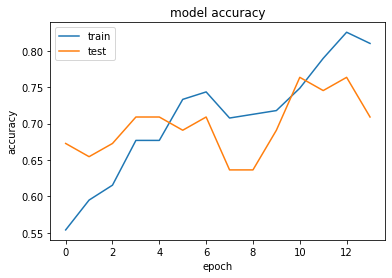

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

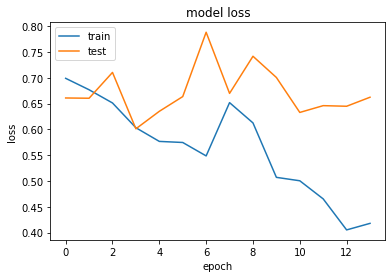

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Sperimentazione Spagnolo Giapponese senza early stopping

In [ ]:
def run_experiment_without_es(model, trainX, trainy, testX, testy):
  model = create_model(trainX, trainy, testX, testy)
  verbose, epochs, batch_size = 0, 30, 32
  model = create_model(trainX, trainy,  testX, testy)
  history = model.fit(trainX, trainy, epochs = epochs, batch_size = batch_size, validation_data = (testX, testy)) 
  model.summary()
  model.evaluate(testX, testy)
  predictions = model.predict_classes(testX) 
  print(predictions)
  return history, predictions

In [ ]:
# run the experiment
trainX, trainy, testX, testy = load_dataset(path_drive+'/'+dataset_dir)
model = create_model(trainX, trainy, testX, testy)
history, predictions = run_experiment_without_es(model, trainX, trainy, testX, testy)

(195, 350, 66) (195, 1)
(55, 350, 66) (55, 1)
(195, 350, 66) (195, 2) (55, 350, 66) (55, 2)
Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


7/7 [==============================] - 33s 3s/step - loss: 0.7127 - accuracy: 0.6071 - val_loss: 0.6553 - val_accuracy: 0.5818
Epoch 2/30
7/7 [==============================] - 14s 2s/step - loss: 0.6827 - accuracy: 0.5665 - val_loss: 0.6899 - val_accuracy: 0.6909
Epoch 3/30
7/7 [==============================] - 15s 2s/step - loss: 0.6356 - accuracy: 0.6256 - val_loss: 0.6154 - val_accuracy: 0.7091
Epoch 4/30
7/7 [==============================] - 15s 2s/step - loss: 0.6403 - accuracy: 0.6407 - val_loss: 0.6146 - val_accuracy: 0.6545
Epoch 5/30
7/7 [==============================] - 15s 2s/step - loss: 0.5808 - accuracy: 0.6736 - val_loss: 0.5885 - val_accuracy: 0.6909
Epoch 6/30
7/7 [==============================] - 17s 2s/step - loss: 0.6125 - accuracy: 0.6749 - val_loss: 0.5640 - val_accuracy: 0.7091
Epoch 7/30
7/7 [==============================] - 15s 2s/step - loss: 0.5235 - accuracy: 0.7260 - val_loss: 0.6184 - val_accuracy: 0.6000
Epoch 8/30
7/7 [=============================

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0
 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1]


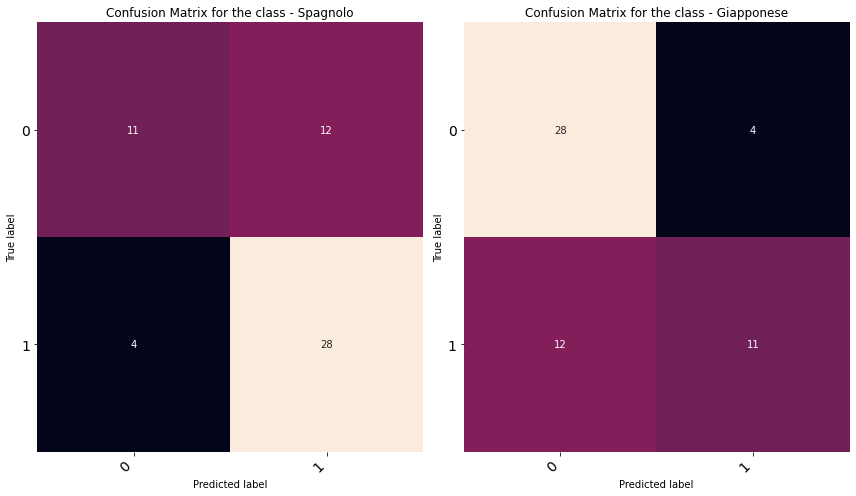

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 7))
labels = list(LANGUAGES.values())
for axes, cfs_matrix, label in zip(ax.flatten(), vis_arr, labels):
    print_confusion_matrix(cfs_matrix, axes, label, list(LANGUAGES_N.values()))
    
fig.tight_layout()
plt.show()

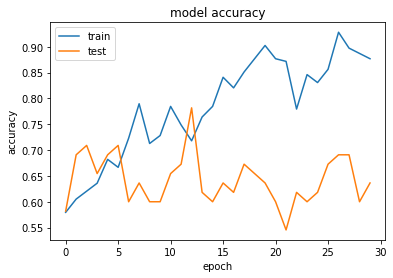

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

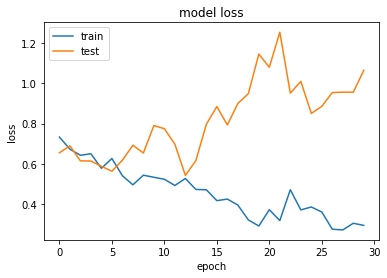

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()